In [12]:
%matplotlib inline 
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torchvision.transforms as T
import os, sys, glob
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
%load_ext autoreload
%autoreload 2
from utils import ProgressMeter, AverageMeter, save_checkpoint, TiffDataset


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
cores_chemo_labels_df = pd.read_csv('../data/cores_labels_chemotherapy.csv')

In [9]:
cores_path = "/data/projects/pixel_project/datasets/NKI_project_TMAs/"
cores_files = []
cores_directories = [d for d in os.listdir(cores_path) if
                     os.path.isdir(os.path.join(cores_path, d)) and d.startswith('TMA')]
cores_files_train = []
cores_files_test = []
cores_labels_train = []
cores_labels_test = []
input_dimensions = (1024, 1024)
batch_size = 8
num_workers = 28
channels = [0, 1, 2]
for i, slide in enumerate(cores_directories):
    files_path = str(cores_path) + "/" + slide + "/Channels_all"
    cores_files.extend([os.path.join(r, fn)
                        for r, ds, fs in os.walk(files_path)
                        for fn in fs if fn.endswith('.tif')])

for i, core_file in enumerate(cores_files):
    patch_file_label_df = cores_chemo_labels_df[(cores_chemo_labels_df['cycif.slide']==core_file.split('/')[-3])&(cores_chemo_labels_df['cycif.core.id']==core_file.split('/')[-1].replace('.tif',''))]
    if not patch_file_label_df.empty and str(patch_file_label_df.iloc[0]['therapy_sequence']).lower()!='na':
        if core_file.split('/')[-3]=='TMA_42_961':
            cores_files_test.append(core_file)
            # If contains NACT, is a sample collected after chemotherapy exposure
            if 'nact' in str(patch_file_label_df.iloc[0]['therapy_sequence']).lower():
                cores_labels_test.append(0)
            else:
                cores_labels_test.append(1)
        else:
            cores_files_train.append(core_file)
            # If contains NACT, is a sample collected after chemotherapy exposure
            if 'nact' in str(patch_file_label_df.iloc[0]['therapy_sequence']).lower():
                cores_labels_train.append(0)
            else:
                cores_labels_train.append(1)
    else:
        print('Missing label for:'+core_file)

tiff_dataset_train = TiffDataset(files=cores_files_train,transform=T.Resize([input_dimensions[0],input_dimensions[1]]), channels=channels,labels=cores_labels_train)
tiff_dataset_test = TiffDataset(files=cores_files_test,transform=T.Resize([input_dimensions[0],input_dimensions[1]]), channels=channels,labels=cores_labels_test)

train_sampler = None
train_loader = torch.utils.data.DataLoader(
        tiff_dataset_train, batch_size=batch_size, shuffle=(train_sampler is None),
         pin_memory=True, sampler=train_sampler, num_workers=num_workers)
test_sampler = None
test_loader = torch.utils.data.DataLoader(
        tiff_dataset_test, batch_size=batch_size, shuffle=(test_sampler is None),
         pin_memory=True, sampler=test_sampler, num_workers=num_workers)


Missing label for:/data/projects/pixel_project/datasets/NKI_project_TMAs//TMA_43_616/Channels_all/core52.tif
Missing label for:/data/projects/pixel_project/datasets/NKI_project_TMAs//TMA_43_616/Channels_all/core65.tif
Missing label for:/data/projects/pixel_project/datasets/NKI_project_TMAs//TMA_42_961/Channels_all/core1.tif
Missing label for:/data/projects/pixel_project/datasets/NKI_project_TMAs//TMA_31_1020/Channels_all/core3.tif


In [21]:
cores_chemo_labels_df
# remove Nan

,cycif.slide,cycif.core.id,patient,Molecular.profile2,figo_stage,therapy_sequence,finalstatus,timelastfu,daystoprogression,progression
0,TMA_34_504,core50,T13-06809,HRD,FIGO III,NACT,2.0,820.0,327.0,1.0
1,TMA_34_504,core65,T13-06809,HRD,FIGO III,NACT,2.0,820.0,327.0,1.0
2,TMA_34_504,core58,T13-06809,HRD,FIGO III,NACT,2.0,820.0,327.0,1.0
3,TMA_34_504,core72,T13-06809,HRD,FIGO III,NACT,2.0,820.0,327.0,1.0
4,TMA_31_1020,core48,T15-01390,HRP,FIGO III,NACT,2.0,846.0,272.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1058,TMA_42_961,core91,T17-61085,BRCAmut/met,FIGO III,Primairy debulking,2.0,505.0,375.0,1.0
1059,TMA_46_325,core3,OC liver,Other,NaN,NaN,NaN,NaN,NaN,NaN
1060,TMA_44_810,core51,T17-61187,BRCAmut/met,FIGO III,Primairy debulking,2.0,1107.0,606.0,1.0
1061,TMA_42_961,core102,T17-60991,Other,NaN,NaN,NaN,NaN,NaN,NaN


tensor(1)


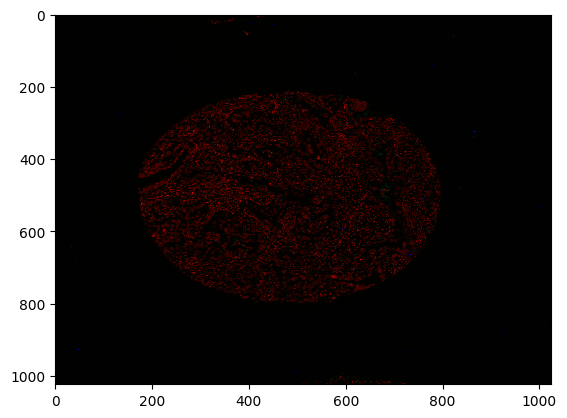

tensor(1)


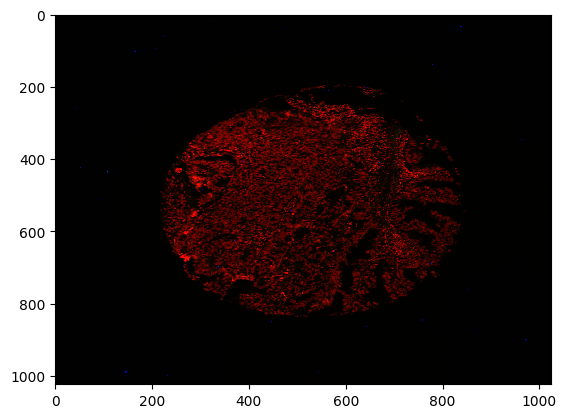

tensor(1)


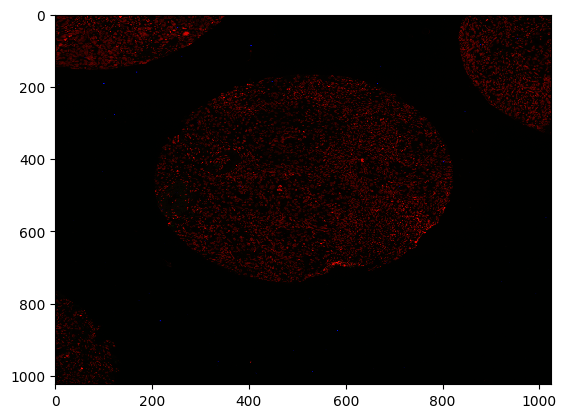

tensor(1)


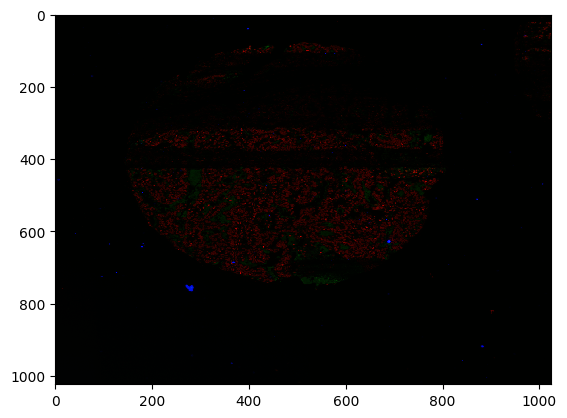

tensor(1)


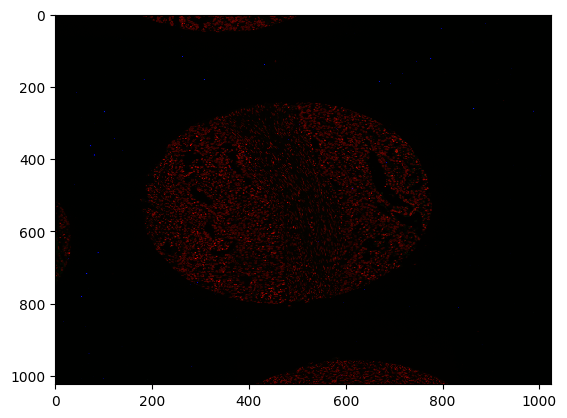

tensor(1)


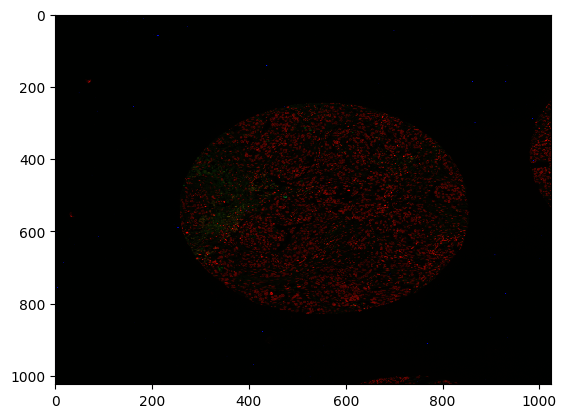

tensor(1)


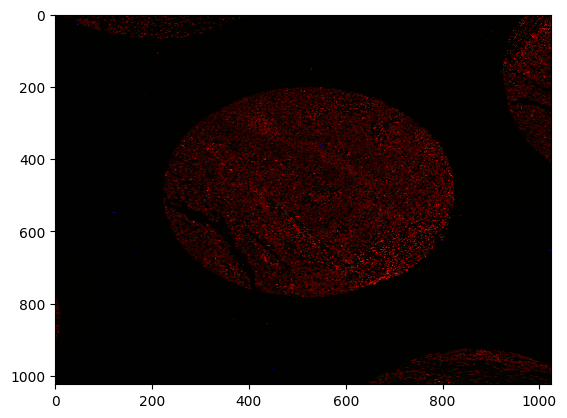

tensor(1)


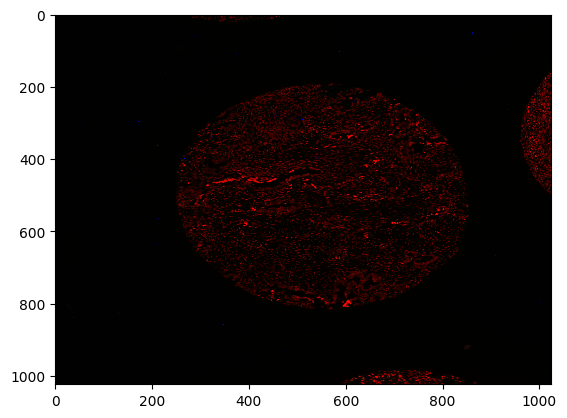

tensor(0)


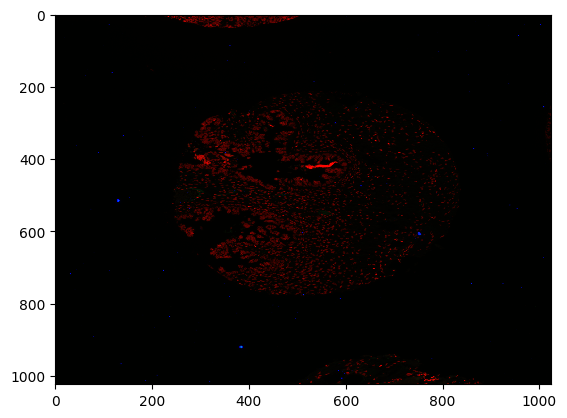

tensor(1)


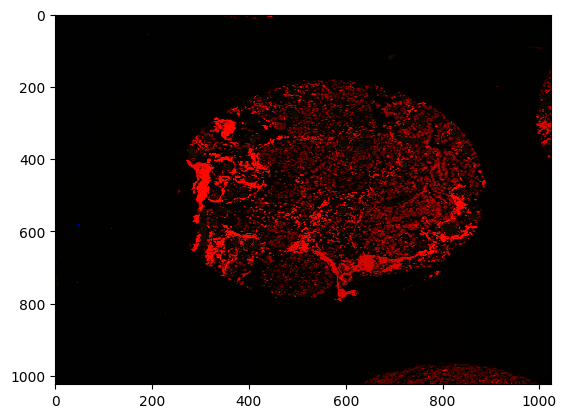

tensor(0)


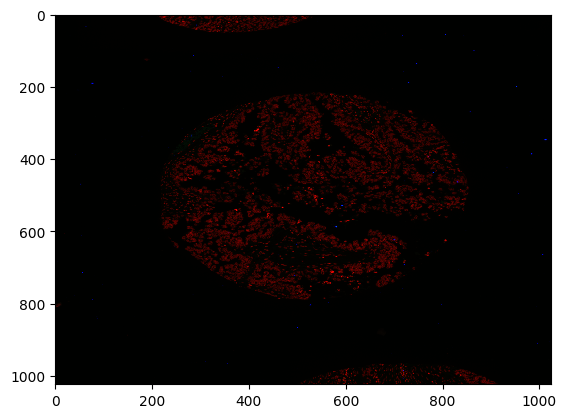

tensor(1)


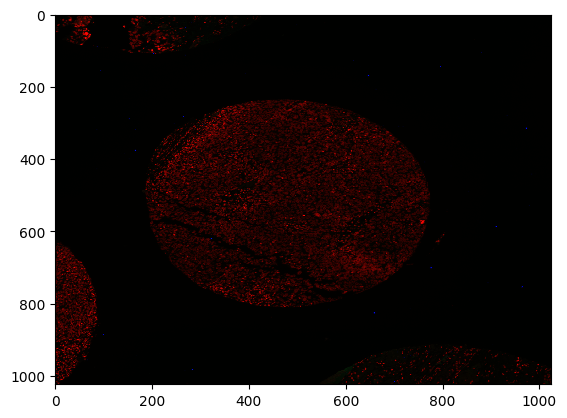

tensor(1)


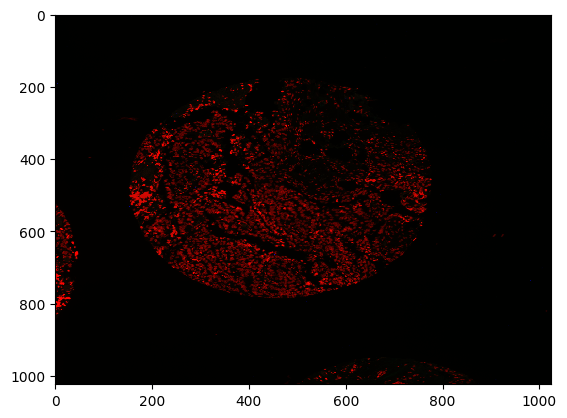

tensor(0)


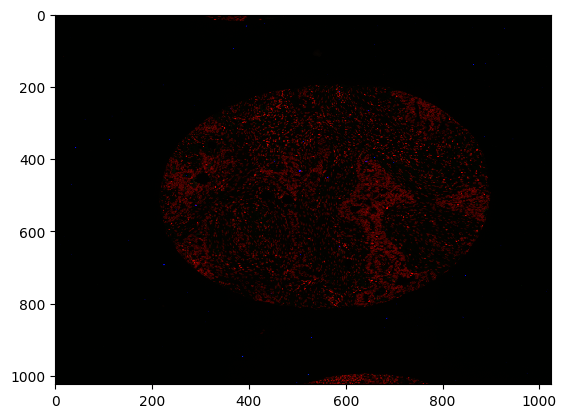

tensor(1)


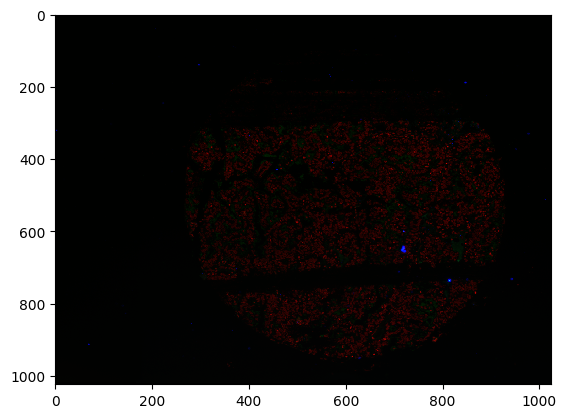

tensor(0)


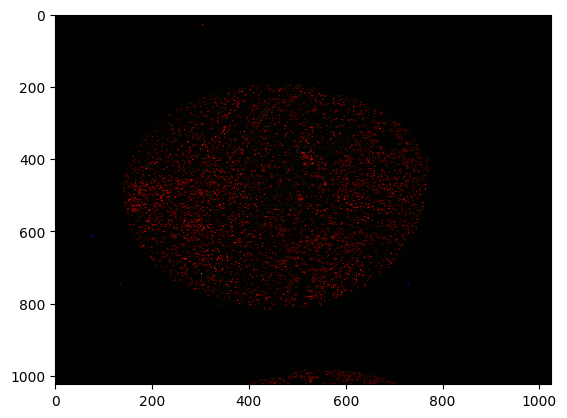

tensor(1)


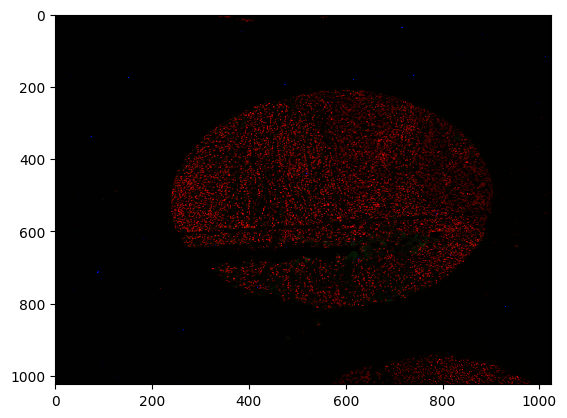

tensor(1)


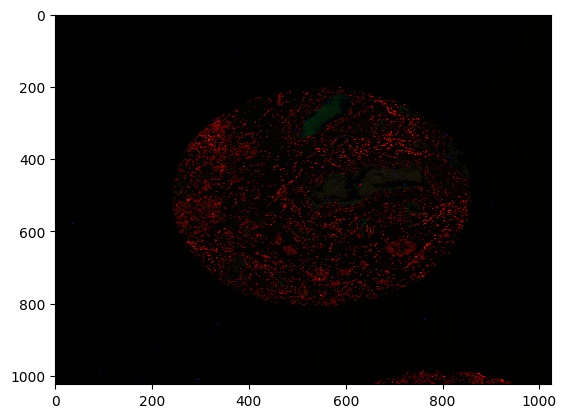

tensor(1)


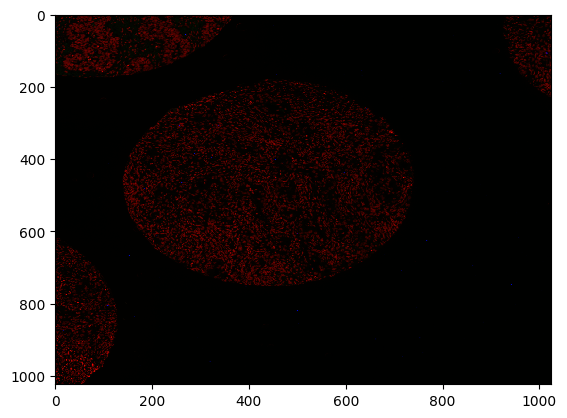

tensor(1)


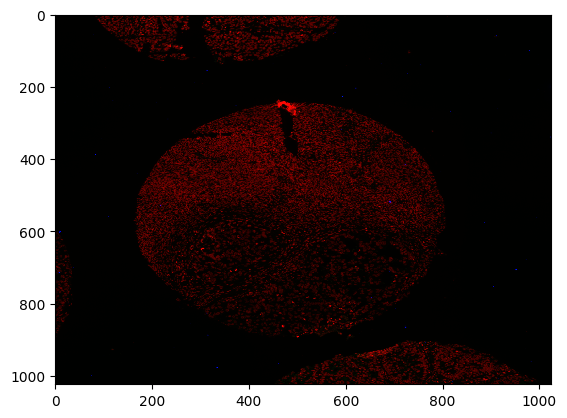

tensor(1)


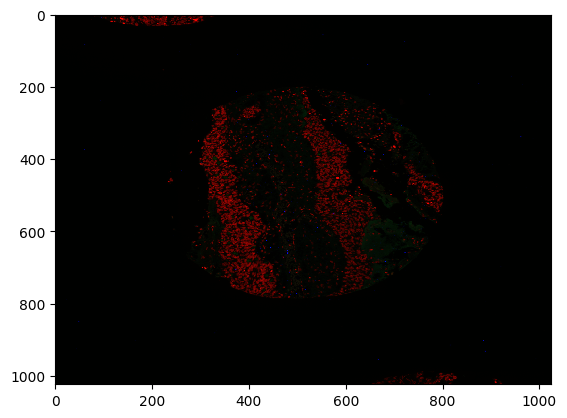

tensor(1)


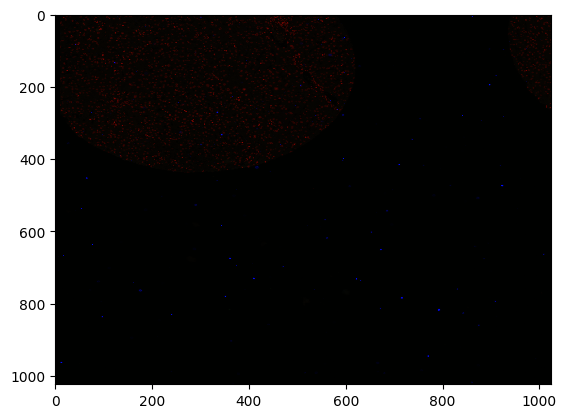

tensor(1)


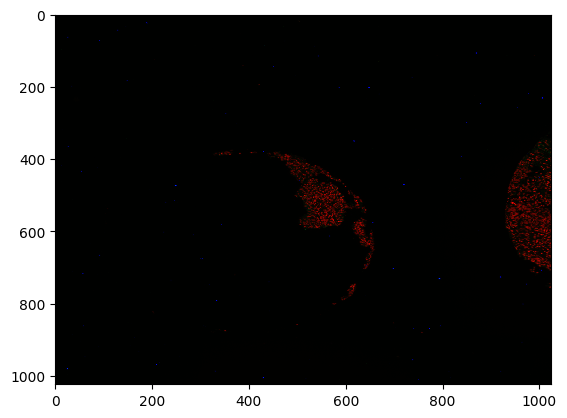

tensor(1)


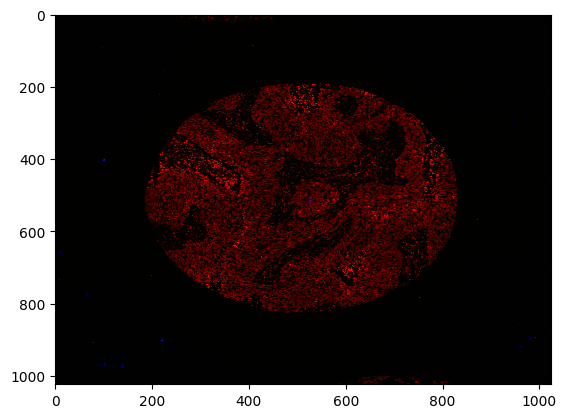

In [19]:
for i, (images, labels) in enumerate(test_loader):
    for batch_i in range(len(images)):
        print(labels[batch_i])
        plt.imshow(images[batch_i].permute(1, 2, 0), interpolation='nearest', aspect='auto')
        plt.show()
    if i>1:
        break